<a href="https://colab.research.google.com/github/YWchris/Effect-of-heterogeneity-and-cluster-analysis/blob/main/Cataract_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here are the explanations of the steps in this notebook:
1. The dataset used is the cataract images, which are from https://www.kaggle.com/code/taha07/cataract-prediction-using-vgg19/data?select=preprocessed_images

2. The preprocessed images are saved to Google drive

3. For all of the images, only images with labels with cataract or normal are selected (and this is for both left and right eyes)

4. Before data splitting, making the number of cataract images = the number of normal images

5. Train-Test split

6. Data augmentation on the training set

6. Train a binary classifier on the training images

7. Use the trained binary classifier(remove the last layer) to extract features from the training images

8. K-means clustering on the training set

9. For images in each of the cluster, train a binary CNN, test the performance of the CNN using the testing set

In [ ]:
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
df = pd.read_csv('gdrive/My Drive/cartact.csv')
len(df)
df.head(3)

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
2  ../input/ocular-disease-recognition-odir5k/ODI...  ['D']   

                     target     filename  
0  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg  
1  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg  
2  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg

In [ ]:
df1 = df.loc[:, ['Patient Age','Patient Sex', 'Left-Fundus', 'Left-Diagnostic Keywords']]
df1.rename(columns = {'Left-Fundus':'Image', 'Left-Diagnostic Keywords':'Result'}, inplace = True)

dat_left = df1.loc[(df1['Result'] == 'cataract')|(df1['Result'] == 'normal fundus')]

df2 = df.loc[:, ['Patient Age','Patient Sex', 'Right-Fundus', 'Right-Diagnostic Keywords']]

df2.rename(columns = {'Right-Fundus':'Image', 'Right-Diagnostic Keywords':'Result'}, inplace = True)
dat_right = df2.loc[(df2['Result'] == 'cataract')|(df2['Result'] == 'normal fundus')]
dat_right.head(10)
data = dat_left.append(dat_right)
len(data)

<ipython-input-5-2838f9dca158>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = dat_left.append(dat_right)


6019

In [ ]:

data_cfe = data[(data["Patient Sex"] == "Female") & (data["Result"] == "cataract")]
data_cm = data[(data["Patient Sex"] == "Male") & (data["Result"] == "cataract")]
# data_cfe = data_cfe.iloc[:220]
print(len(data_cfe), len(data_cm))
data_nfe = data[(data["Patient Sex"] == "Female") & (data["Result"] == "normal fundus")]
data_nfe = data_nfe.iloc[:298]
data_nm = data[(data["Patient Sex"] == "Male") & (data["Result"] == "normal fundus")]
data_nm = data_nm.iloc[:220]
print(len(data_nfe), len(data_nm))
frame_data = [data_cfe, data_cm, data_nfe, data_nm]
data = pd.concat(frame_data)
data = data.sample(frac = 1, random_state=42)
len(data)

298 220
298 220


1036

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data,
                                   test_size = 0.20,
                                   random_state = 2023,
                                   stratify = data[['Result']])

In [ ]:
# have a look at the proportion of gender in training data
dat1 = train_df[(train_df["Patient Sex"] == "Female") & (train_df["Result"] == "cataract")]
dat2 = train_df[(train_df["Patient Sex"] == "Male") & (train_df["Result"] == "cataract")]

print(len(dat1), len(dat2))

dat3 = train_df[(train_df["Patient Sex"] == "Female") & (train_df["Result"] == "normal fundus")]
dat4 = train_df[(train_df["Patient Sex"] == "Male") & (train_df["Result"] == "normal fundus")]

print(len(dat3), len(dat4))

231 183
241 173


In [ ]:
dat_cataract = train_df[(train_df["Result"] == "cataract")]
dat_normal = train_df[(train_df["Result"] == "normal fundus")]
frame_data = [dat_cataract, dat_normal]
train_df = pd.concat(frame_data)
print(len(train_df))

828


In [ ]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
train_df.index.values
#test_df.index.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
# select the images (cataract & normal) for training
train_cataract = train_df.loc[(train_df["Result"] == "cataract")]["Image"].values
train_normal = train_df.loc[(train_df["Result"] == "normal fundus")]["Image"].values

In [ ]:
# select the images (cataract & normal) for testing
test_cataract = test_df.loc[(test_df["Result"] == "cataract")]["Image"].values
test_normal = test_df.loc[(test_df["Result"] == "normal fundus")]["Image"].values

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
REQUIRES_PYTHON = '>=3.5.0'
VERSION = '0.1.0'
from torch import optim, nn
from torchvision import models, transforms

In [ ]:
data_path='/content/drive/MyDrive/dataimage'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

from google.colab import drive
drive.mount('/content/drive')

On which device we are on:cpu
Mounted at /content/drive


In [ ]:
# create training dataset, with x=images, y =label(1 is cataract, 0 is normal)
def preprocess_image(image_path, target_height=224, target_width=224):
    """
    This function resizes and converts the image to greyscale. By default, resize all images to 224 X 224.
    """

    import cv2
    # Read the image in color format
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the image to the target dimensions using bilinear interpolation
    resized = cv2.resize(gray, (target_width, target_height), interpolation=cv2.INTER_LINEAR)

    # Normalize the image by dividing by 255 to scale pixel values between 0 and 1
    normalized_img = resized / 255.0

    return normalized_img

from pandas.core.common import random_state
import cv2
import glob
from PIL import Image
image_size=224
labels = []
dataset = []
random.seed(2023)
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(data_path,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue

        dataset.append([image,label])

    return dataset

dataset = create_dataset(train_cataract,1)

dataset = create_dataset(train_normal,0)
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3) #features
y = np.array([i[1] for i in dataset]) #labels
len(x)
len(y)

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

828

In [ ]:
dataset[800][1]

0

In [ ]:
# create testing dataset, with x=images, y =label(1 is cataract, 0 is normal)
from pandas.core.common import random_state
import cv2
import glob
image_size=224
labels = []
dataset = []
random.seed(1)
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(data_path,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue

        dataset.append([np.array(image),np.array(label)])
    return dataset

test_dataset = create_dataset(test_cataract,1)

test_dataset = create_dataset(test_normal,0)

x_testall = np.array([i[0] for i in test_dataset]).reshape(-1,image_size,image_size,3) #features
y_testall = np.array([i[1] for i in test_dataset]) #labels
len(x_testall)
len(y_testall)

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

208

In [ ]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.9.0

Found existing installation: tensorflow 2.9.0
Uninstalling tensorflow-2.9.0:
  Successfully uninstalled tensorflow-2.9.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-2.9.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(x)

In [ ]:
# Augmentation: Training data
batch_size = 8
num_augmented = 828

augmented_images = np.zeros((num_augmented, image_size, image_size, 3))
for i in range(num_augmented):
    img = x[i % len(x)]  # select an image from the original dataset
    augmented_images[i] = datagen.random_transform(img)

x_aug = np.concatenate((x, augmented_images), axis=0)
y_aug = np.concatenate((y, y[:num_augmented]), axis=0)
y_aug[:len(y)] = y  # repeat the original output data to match the number of samples in x_aug

In [ ]:
print(len(x_aug), len(y_aug))

1656 1656


In [ ]:
# Import base model efficientNetB0 for feature extraction
import numpy as np
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import EfficientNetB0
from keras.optimizers import Adam
from keras.utils import np_utils


Here is the feature extractor trained from the input data

In [ ]:
# Fit the basemodel EfficientNet
import numpy as np
import keras
from keras.applications.efficientnet import EfficientNetB0
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

for layer in efficientnet.layers:
    layer.trainable = False

base_model = Sequential()
base_model.add(efficientnet)
base_model.add(Flatten())
base_model.add(Dense(1,activation="sigmoid"))
base_model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

checkpoint = ModelCheckpoint("base_model.h5", monitor="val_accuracy", verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor="val_accuracy", patience=3, verbose=1, mode='auto', restore_best_weights=True)
history1 = base_model.fit(x_aug, y_aug, batch_size=8, epochs=10, validation_data=(x_testall, y_testall), verbose=1, callbacks = [checkpoint, earlystop])

Epoch 1/10
207/207 [==============================] - ETA: 0s - loss: 0.6131 - accuracy: 0.9076
Epoch 1: val_accuracy improved from -inf to 0.91827, saving model to base_model.h5
207/207 [==============================] - 151s 691ms/step - loss: 0.6131 - accuracy: 0.9076 - val_loss: 0.6019 - val_accuracy: 0.9183
Epoch 2/10
207/207 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.9517
Epoch 2: val_accuracy did not improve from 0.91827
207/207 [==============================] - 131s 633ms/step - loss: 0.2751 - accuracy: 0.9517 - val_loss: 0.7306 - val_accuracy: 0.9087
Epoch 3/10
207/207 [==============================] - ETA: 0s - loss: 0.1837 - accuracy: 0.9704
Epoch 3: val_accuracy improved from 0.91827 to 0.92788, saving model to base_model.h5
207/207 [==============================] - 130s 631ms/step - loss: 0.1837 - accuracy: 0.9704 - val_loss: 0.5254 - val_accuracy: 0.9279
Epoch 4/10
207/207 [==============================] - ETA: 0s - loss: 0.1991 - accuracy

7/7 [==============================] - 19s 2s/step
Accuracy: 97.12%
AUC Score: 0.99
Sensitivity: 97.12%
Specificity: 97.12%


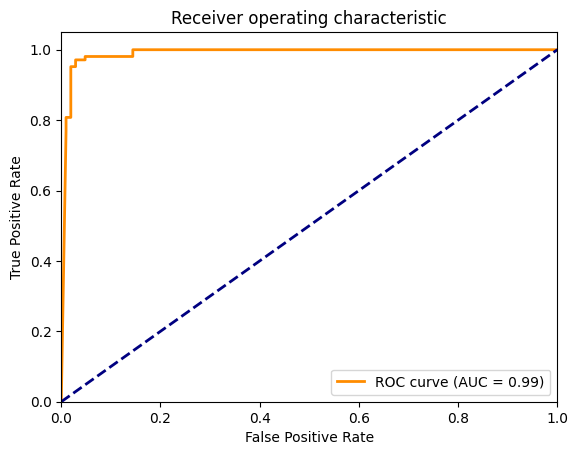

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Make predictions on the test set
predictions = base_model.predict(x_testall)

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_testall, predictions)

# Compute the AUC score
auc_score = roc_auc_score(y_testall, predictions)

# Print the performance metrics
print("Accuracy: {:.2f}%".format(accuracy_score(y_testall, np.round(predictions)) * 100))
print("AUC Score: {:.2f}".format(auc_score))
tn, fp, fn, tp = confusion_matrix(y_testall, np.round(predictions)).ravel()
print("Sensitivity: {:.2f}%".format(tp / (tp + fn) * 100))
print("Specificity: {:.2f}%".format(tn / (tn + fp) * 100))

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Feature extractor
from keras.models import Model

# Remove the last layer (Dense layer)
feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

# Extract features from the data
features = feature_extractor.predict(x_aug)

52/52 [==============================] - 135s 3s/step


In [ ]:
features_df = pd.DataFrame(features.reshape(features.shape[0], -1))
features_df.shape

(1656, 62720)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format='retina'
X_std = StandardScaler().fit_transform(features_df)
pca = PCA(n_components=200)
principalComponents = pca.fit_transform(X_std)
print(principalComponents.shape)

(1656, 200)


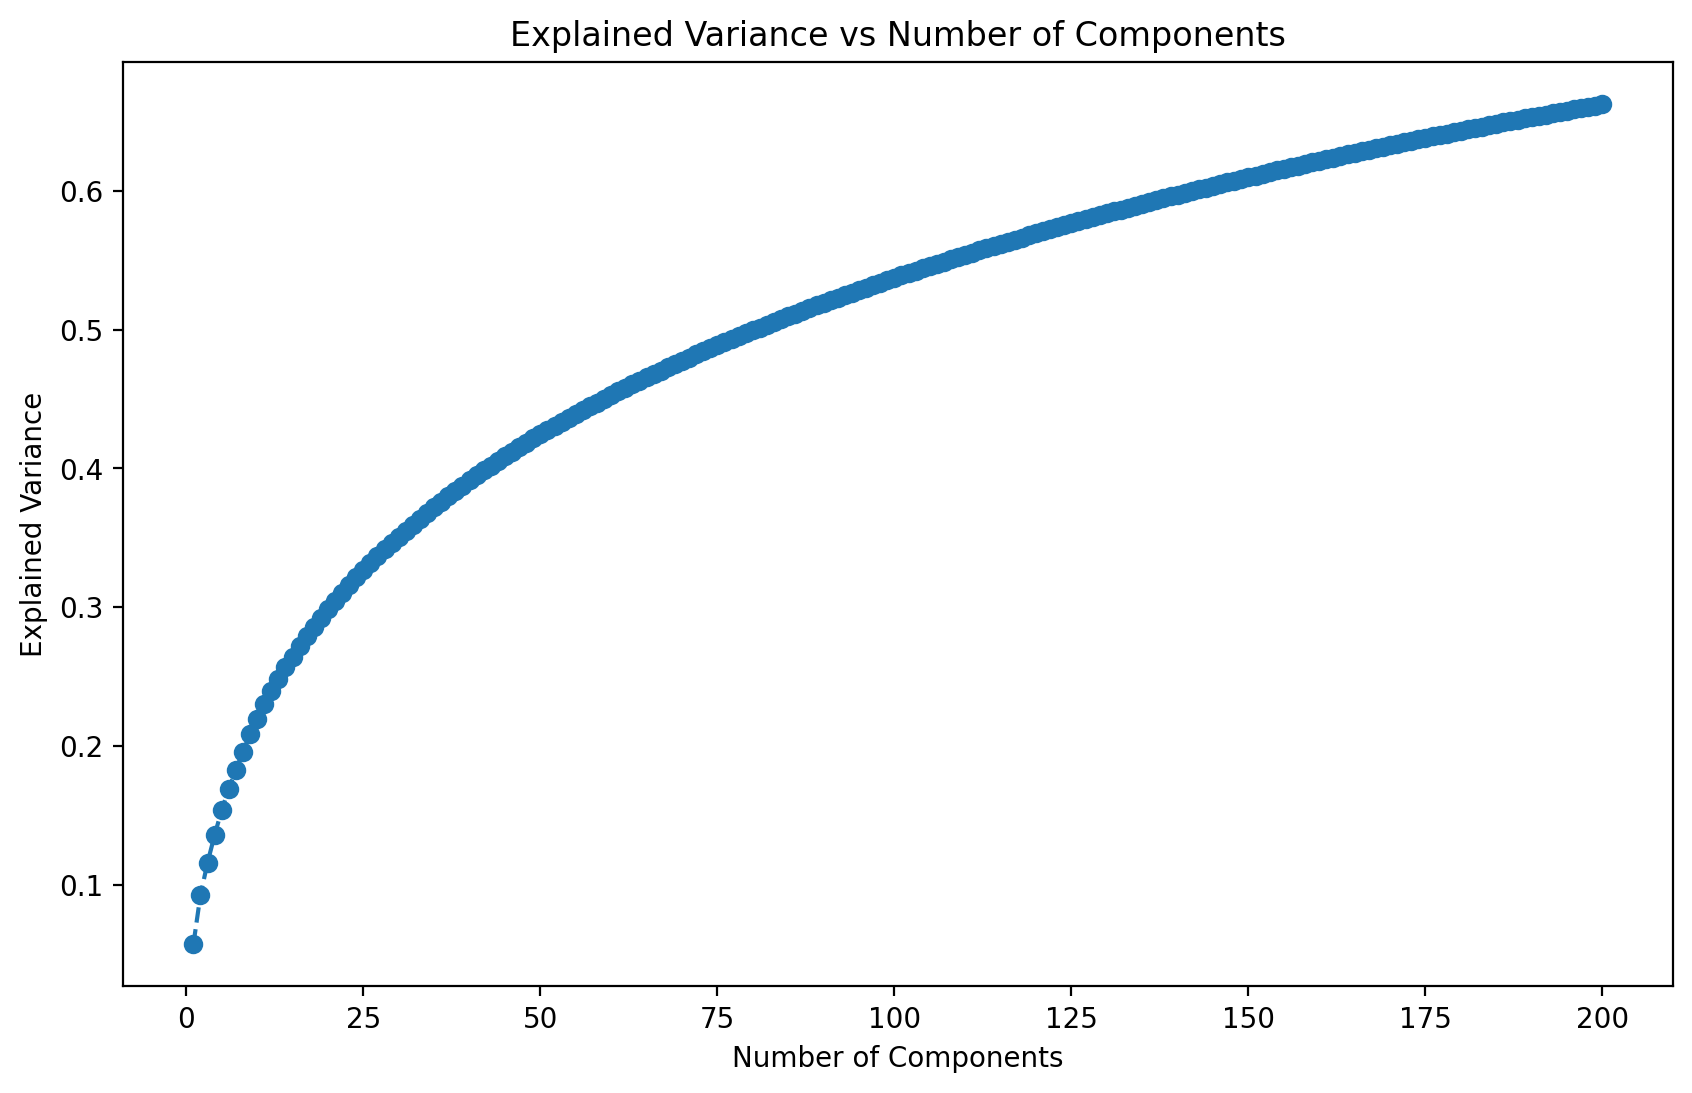

In [ ]:
import matplotlib.pyplot as plt

# Create a plot of explained variance vs number of components
plt.figure(figsize=(10,6))
plt.plot(range(1,201), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.show()

In [ ]:
test_features = feature_extractor.predict(x_testall)
test_features_df = pd.DataFrame(test_features.reshape(test_features.shape[0], -1))
len(test_features_df)

7/7 [==============================] - 19s 2s/step


208

In [ ]:
print(test_features.shape)

(208, 62720)


In [ ]:
Xtest_std = StandardScaler().fit_transform(test_features_df)
test_pca = pca.fit_transform(Xtest_std)
print(test_pca.shape)

(208, 200)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(principalComponents)
test_cluster_labels = kmeans.predict(test_pca)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


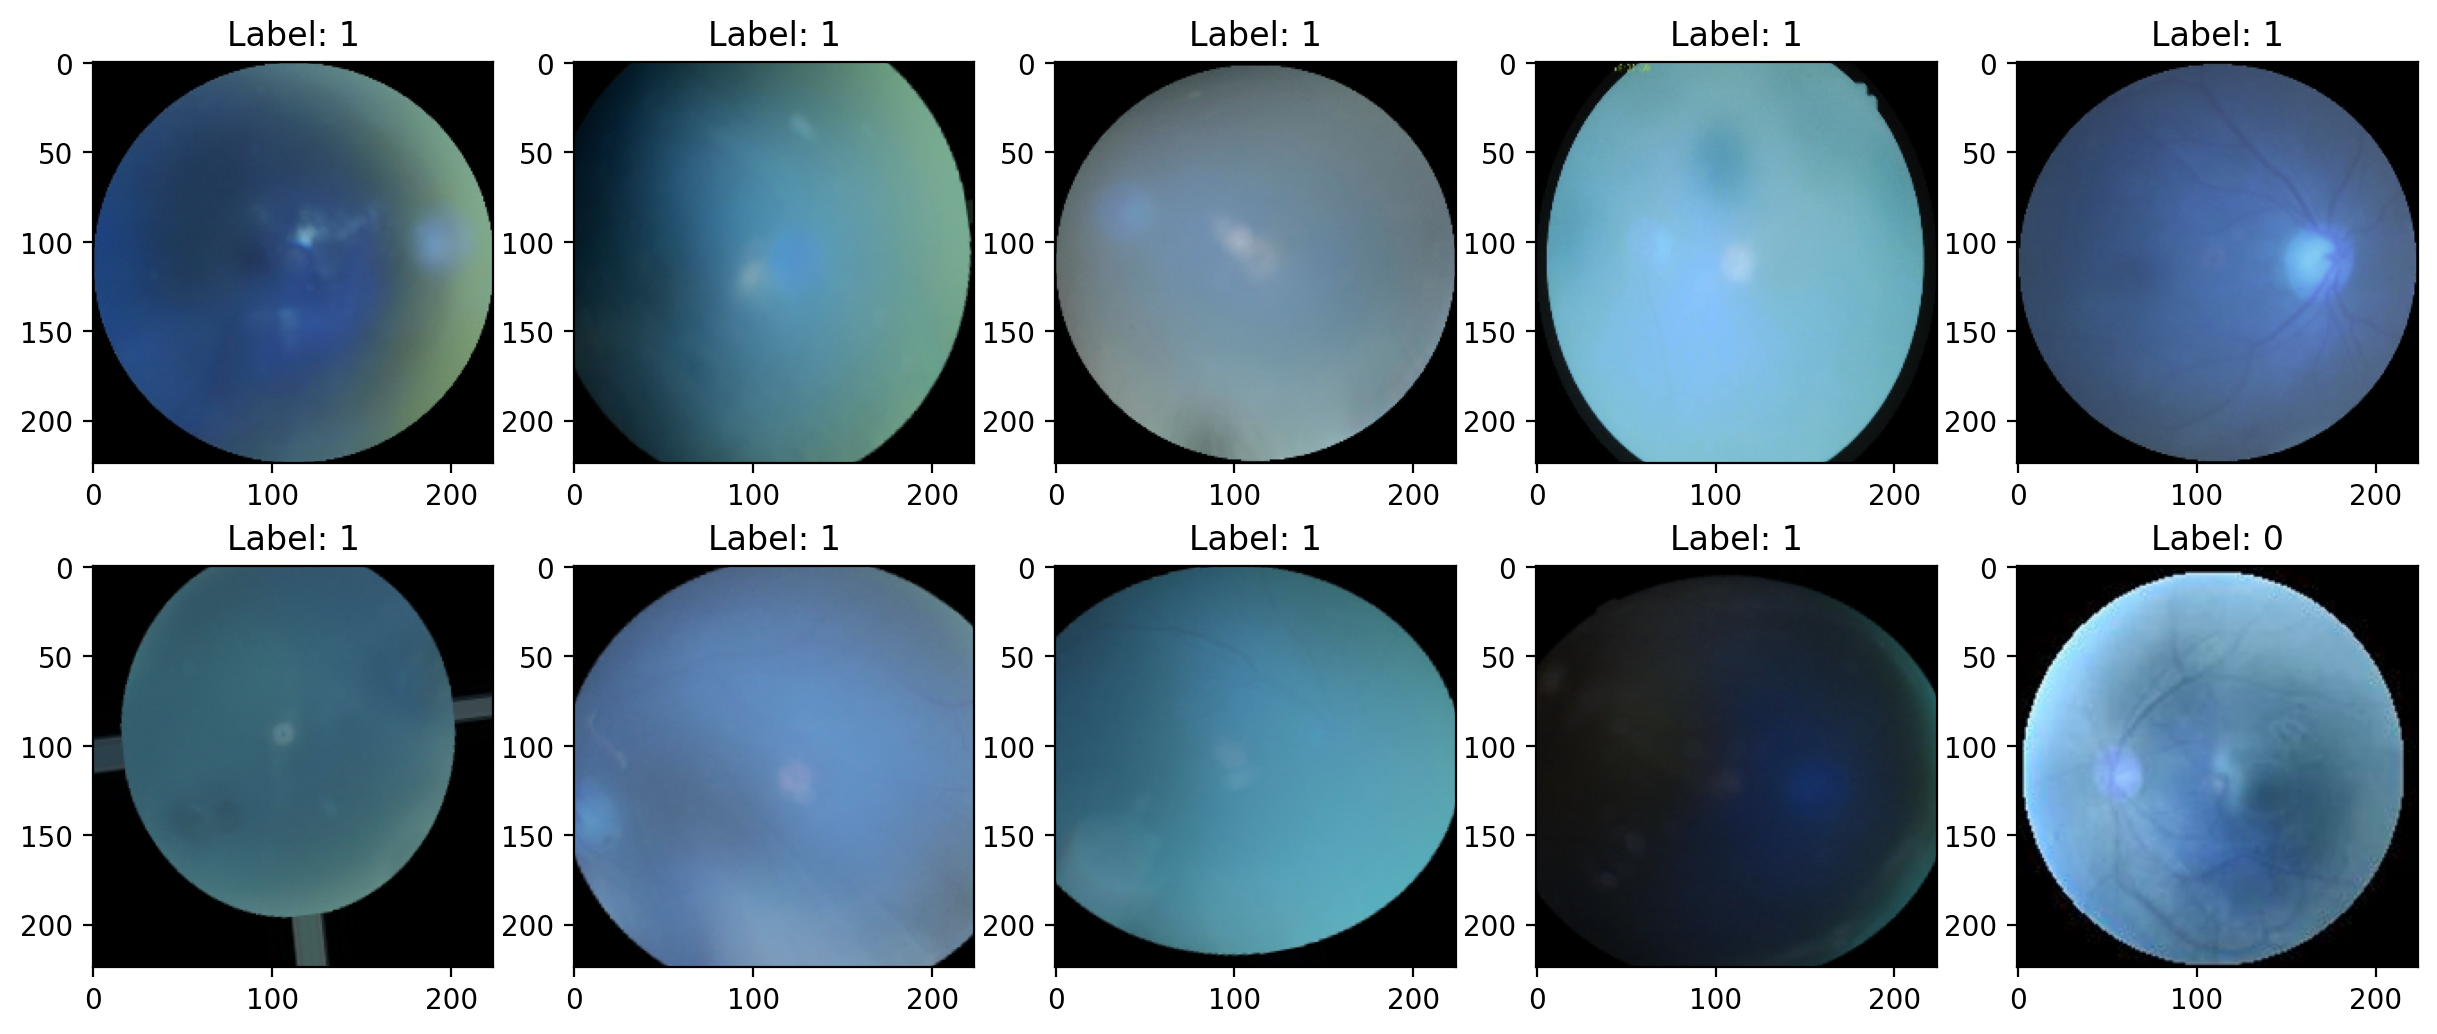

There are 697 images labeled 1 in cluster 1.
There are 65 images labeled 0 in cluster 1.
Average intra-cluster distance: 223.31701477906225


In [ ]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
# get the indices of images in the first cluster
cluster1_indices = np.where(cluster_labels == 0)[0]

# randomly select 10 indices from the cluster
random_indices = random.sample(list(cluster1_indices), 10)

# plot the randomly selected images
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axs = axs.ravel()
for i, index in enumerate(random_indices):
    axs[i].imshow(x_aug[index]/255)
    axs[i].set_title(f"Label: {y_aug[index]}")
plt.show()

c1_num_label_1 = np.count_nonzero(y_aug[cluster1_indices] == 1)

print(f"There are {c1_num_label_1} images labeled 1 in cluster 1.")

c1_num_label_0 = np.count_nonzero(y_aug[cluster1_indices] == 0)

print(f"There are {c1_num_label_0} images labeled 0 in cluster 1.")

# select rows corresponding to cluster1_indices in principalComponents
cluster1_features = principalComponents[cluster1_indices]

# calculate pairwise distances between images in cluster 1
distances = pdist(cluster1_features)

# convert distances to a distance matrix
distance_matrix = squareform(distances)
# calculate average intra-cluster distance
intra_cluster_distance = np.mean(distance_matrix)

print("Average intra-cluster distance:", intra_cluster_distance)

In [ ]:
cluster1_indices

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   17,   18,   19,   20,   21,   22,
         23,   24,   25,   26,   28,   29,   30,   31,   32,   33,   34,
         36,   37,   38,   39,   41,   42,   43,   44,   45,   46,   47,
         48,   49,   50,   51,   52,   53,   54,   55,   56,   57,   58,
         59,   60,   61,   63,   64,   65,   66,   67,   68,   69,   70,
         71,   72,   73,   74,   75,   76,   77,   78,   79,   80,   81,
         84,   85,   86,   87,   88,   89,   90,   91,   92,   93,   94,
         95,   96,   97,   98,   99,  100,  101,  102,  103,  104,  105,
        106,  107,  108,  110,  111,  112,  113,  114,  115,  116,  117,
        118,  119,  120,  121,  122,  124,  125,  126,  127,  128,  129,
        130,  131,  133,  134,  135,  136,  137,  138,  139,  141,  142,
        143,  145,  146,  147,  148,  149,  151,  152,  153,  154,  155,
        156,  157,  159,  160,  161,  162,  163,  1

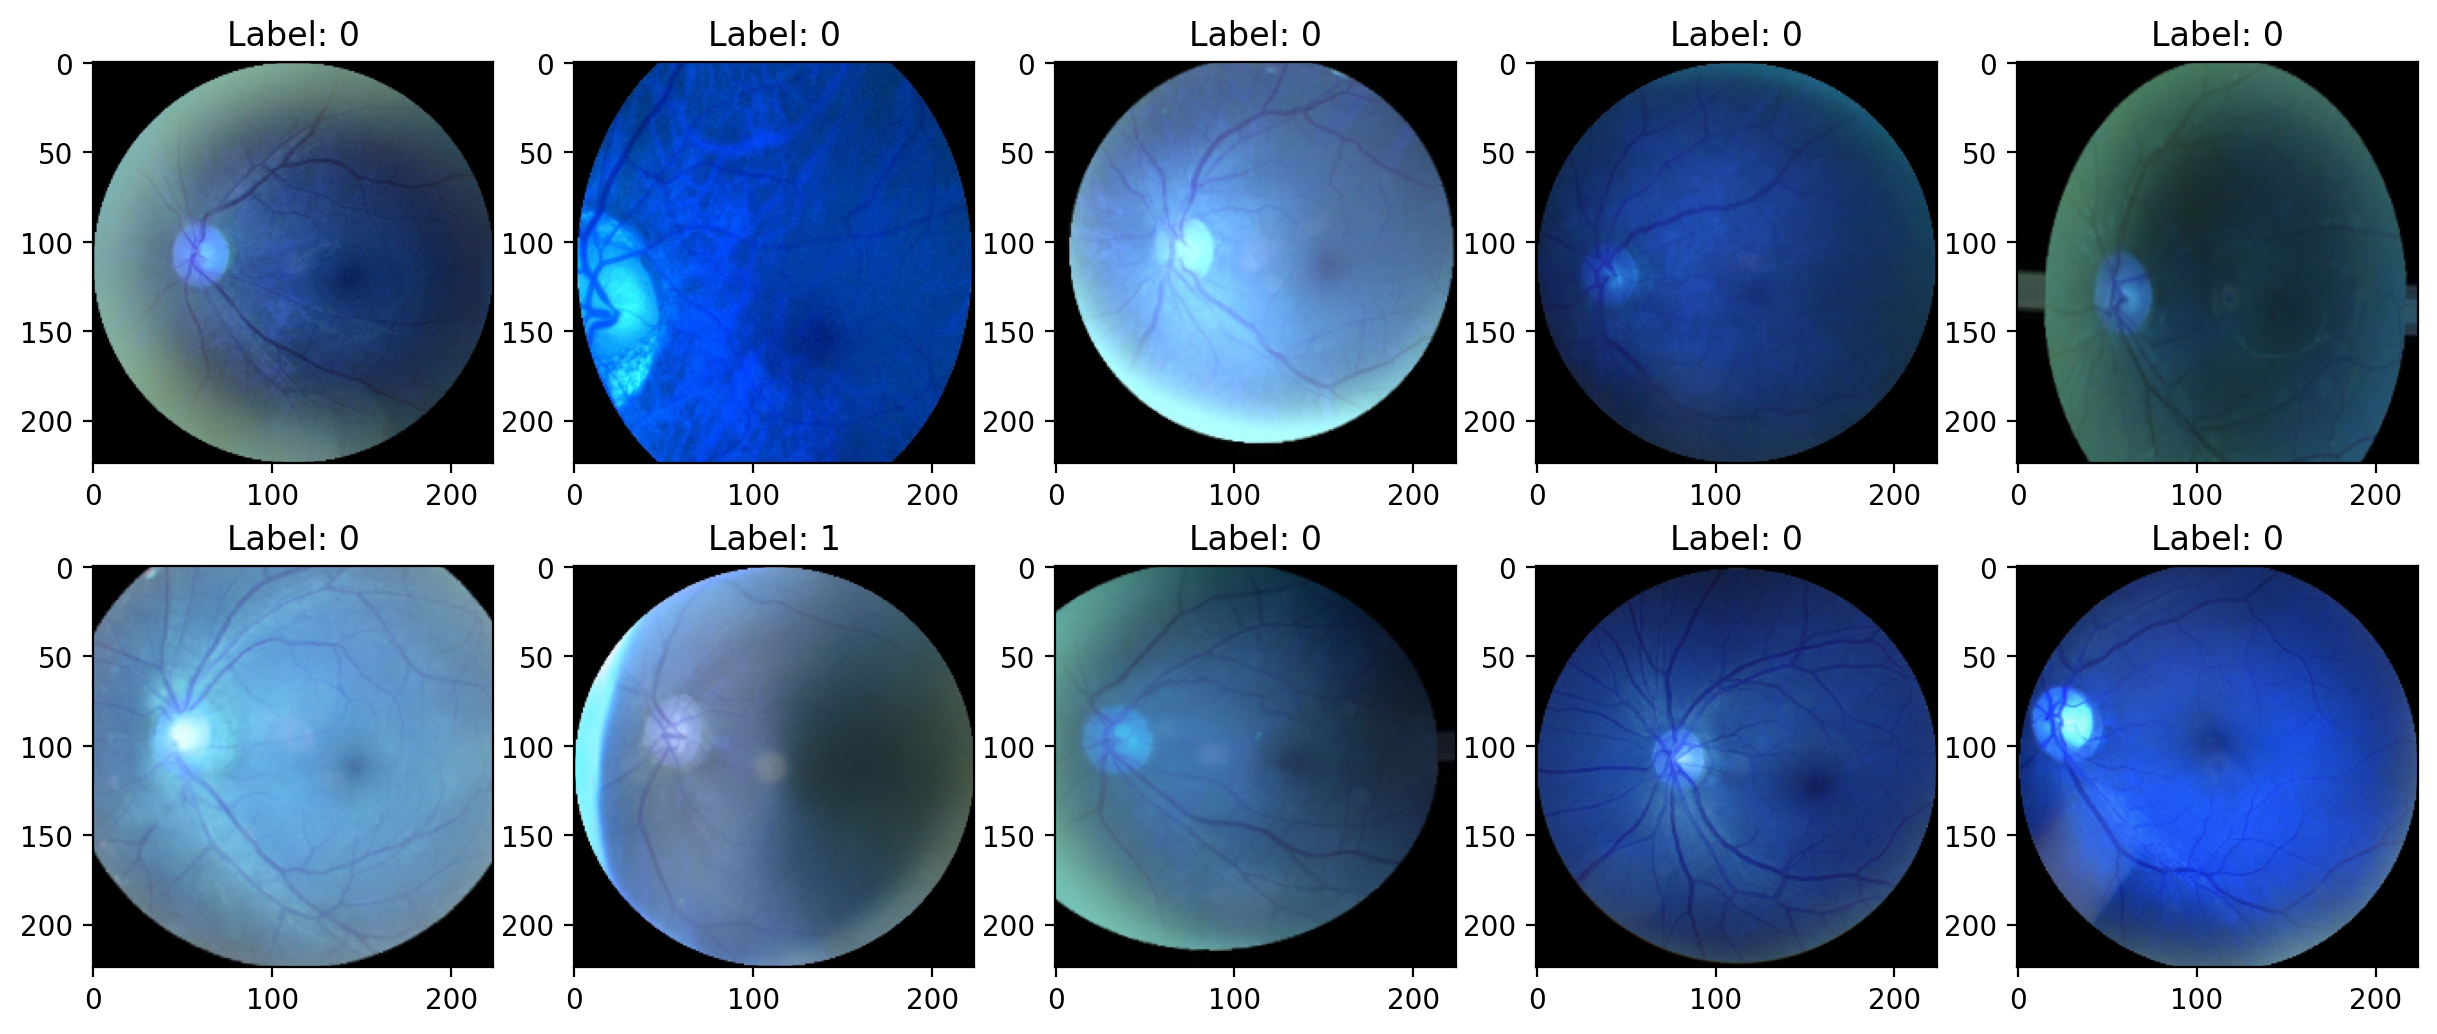

There are 19 images labeled 1 in cluster 2.
There are 500 images labeled 0 in cluster 2.
Average intra-cluster distance: 196.26553929140397


In [ ]:

cluster2_indices = np.where(cluster_labels == 1)[0]

# randomly select 10 indices from the cluster
random_indices = random.sample(list(cluster2_indices), 10)

# plot the randomly selected images
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axs = axs.ravel()
for i, index in enumerate(random_indices):
    axs[i].imshow(x_aug[index]/255)
    axs[i].set_title(f"Label: {y_aug[index]}")
plt.show()

c2_num_label_1 = np.count_nonzero(y_aug[cluster2_indices] == 1)

print(f"There are {c2_num_label_1} images labeled 1 in cluster 2.")

c2_num_label_0 = np.count_nonzero(y_aug[cluster2_indices] == 0)

print(f"There are {c2_num_label_0} images labeled 0 in cluster 2.")


cluster2_features = principalComponents[cluster2_indices]

distances = pdist(cluster2_features)

distance_matrix = squareform(distances)

# calculate average intra-cluster distance
intra_cluster_distance = np.mean(distance_matrix)

print("Average intra-cluster distance:", intra_cluster_distance)

In [ ]:
cluster2_indices

array([  16,   62,   83,  109,  150,  193,  222,  262,  275,  276,  279,
        367,  414,  415,  416,  417,  418,  419,  420,  421,  422,  423,
        424,  425,  427,  428,  429,  430,  431,  432,  434,  435,  436,
        437,  439,  440,  441,  442,  443,  444,  445,  446,  447,  448,
        450,  451,  452,  453,  454,  455,  456,  457,  460,  461,  462,
        463,  465,  466,  467,  468,  469,  470,  471,  472,  473,  474,
        475,  476,  477,  478,  479,  480,  481,  482,  483,  485,  486,
        487,  488,  490,  491,  492,  493,  496,  497,  498,  500,  501,
        502,  503,  504,  505,  506,  507,  508,  509,  510,  511,  512,
        513,  514,  515,  516,  517,  518,  519,  520,  521,  523,  524,
        525,  526,  527,  528,  529,  530,  531,  532,  534,  535,  536,
        537,  538,  539,  540,  541,  542,  543,  544,  545,  546,  547,
        548,  549,  550,  551,  553,  554,  556,  557,  558,  559,  560,
        561,  562,  563,  565,  566,  567,  568,  5

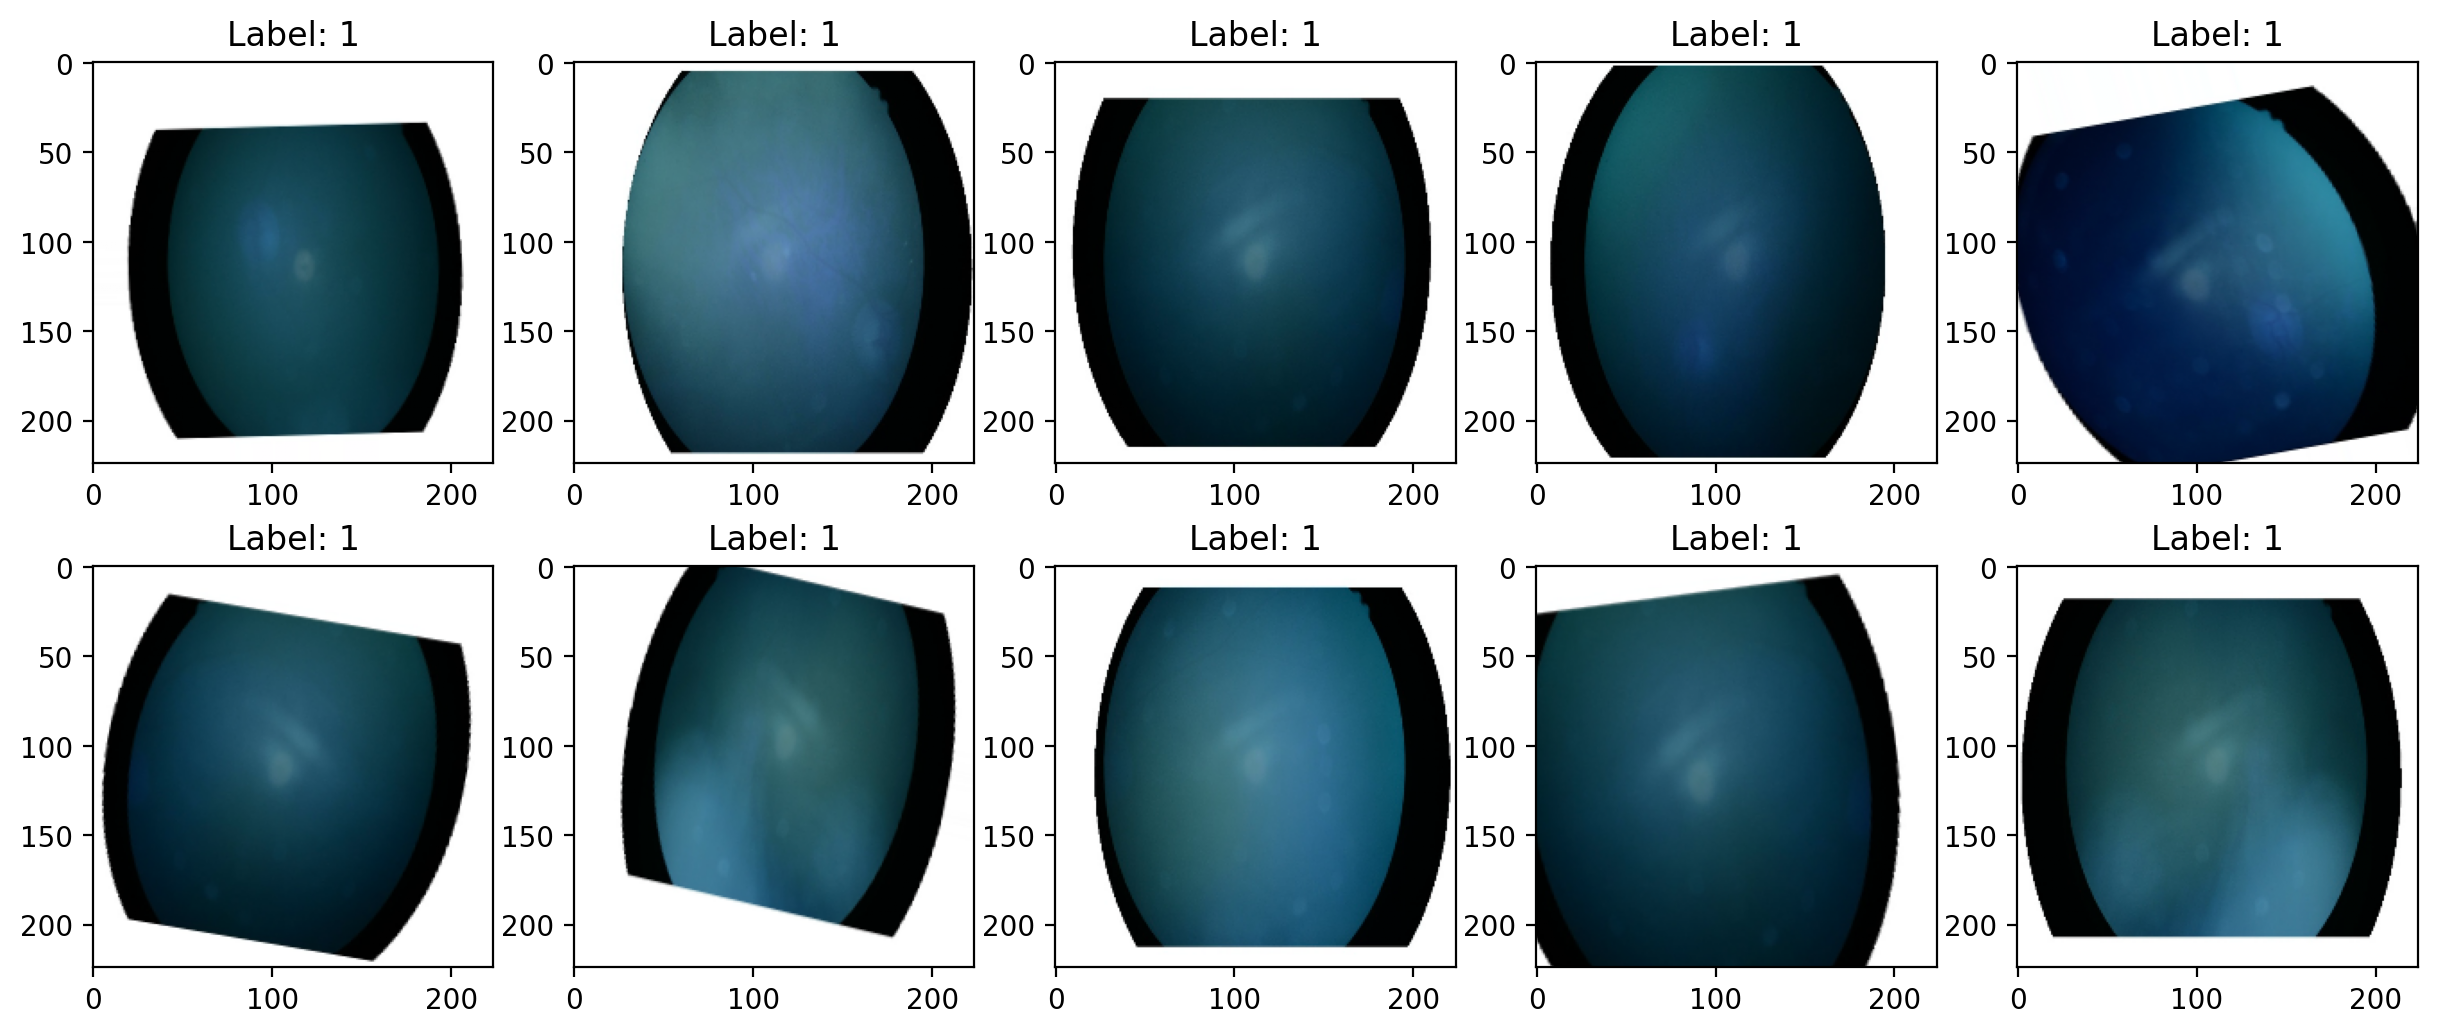

There are 42 images labeled 1 in cluster 3.
There are 0 images labeled 0 in cluster 3.
Average intra-cluster distance: 306.43549503288983


In [ ]:

cluster3_indices = np.where(cluster_labels == 2)[0]

# randomly select 10 indices from the cluster
random_indices = random.sample(list(cluster3_indices), 10)

# plot the randomly selected images
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axs = axs.ravel()
for i, index in enumerate(random_indices):
    axs[i].imshow(x_aug[index]/255)
    axs[i].set_title(f"Label: {y_aug[index]}")
plt.show()

c3_num_label_1 = np.count_nonzero(y_aug[cluster3_indices] == 1)

print(f"There are {c3_num_label_1} images labeled 1 in cluster 3.")

c3_num_label_0 = np.count_nonzero(y_aug[cluster3_indices] == 0)

print(f"There are {c3_num_label_0} images labeled 0 in cluster 3.")

cluster3_features = principalComponents[cluster3_indices]

distances = pdist(cluster3_features)
distance_matrix = squareform(distances)

# calculate average intra-cluster distance
intra_cluster_distance = np.mean(distance_matrix)

print("Average intra-cluster distance:", intra_cluster_distance)

In [ ]:
cluster3_indices

array([  27,   35,   40,   82,  132,  140,  144,  158,  186,  227,  240,
        331,  345,  349,  361,  366,  372,  386,  387,  390,  402,  855,
        863,  868,  910,  960,  968,  972,  986, 1014, 1055, 1068, 1159,
       1173, 1177, 1189, 1194, 1200, 1214, 1215, 1218, 1230])

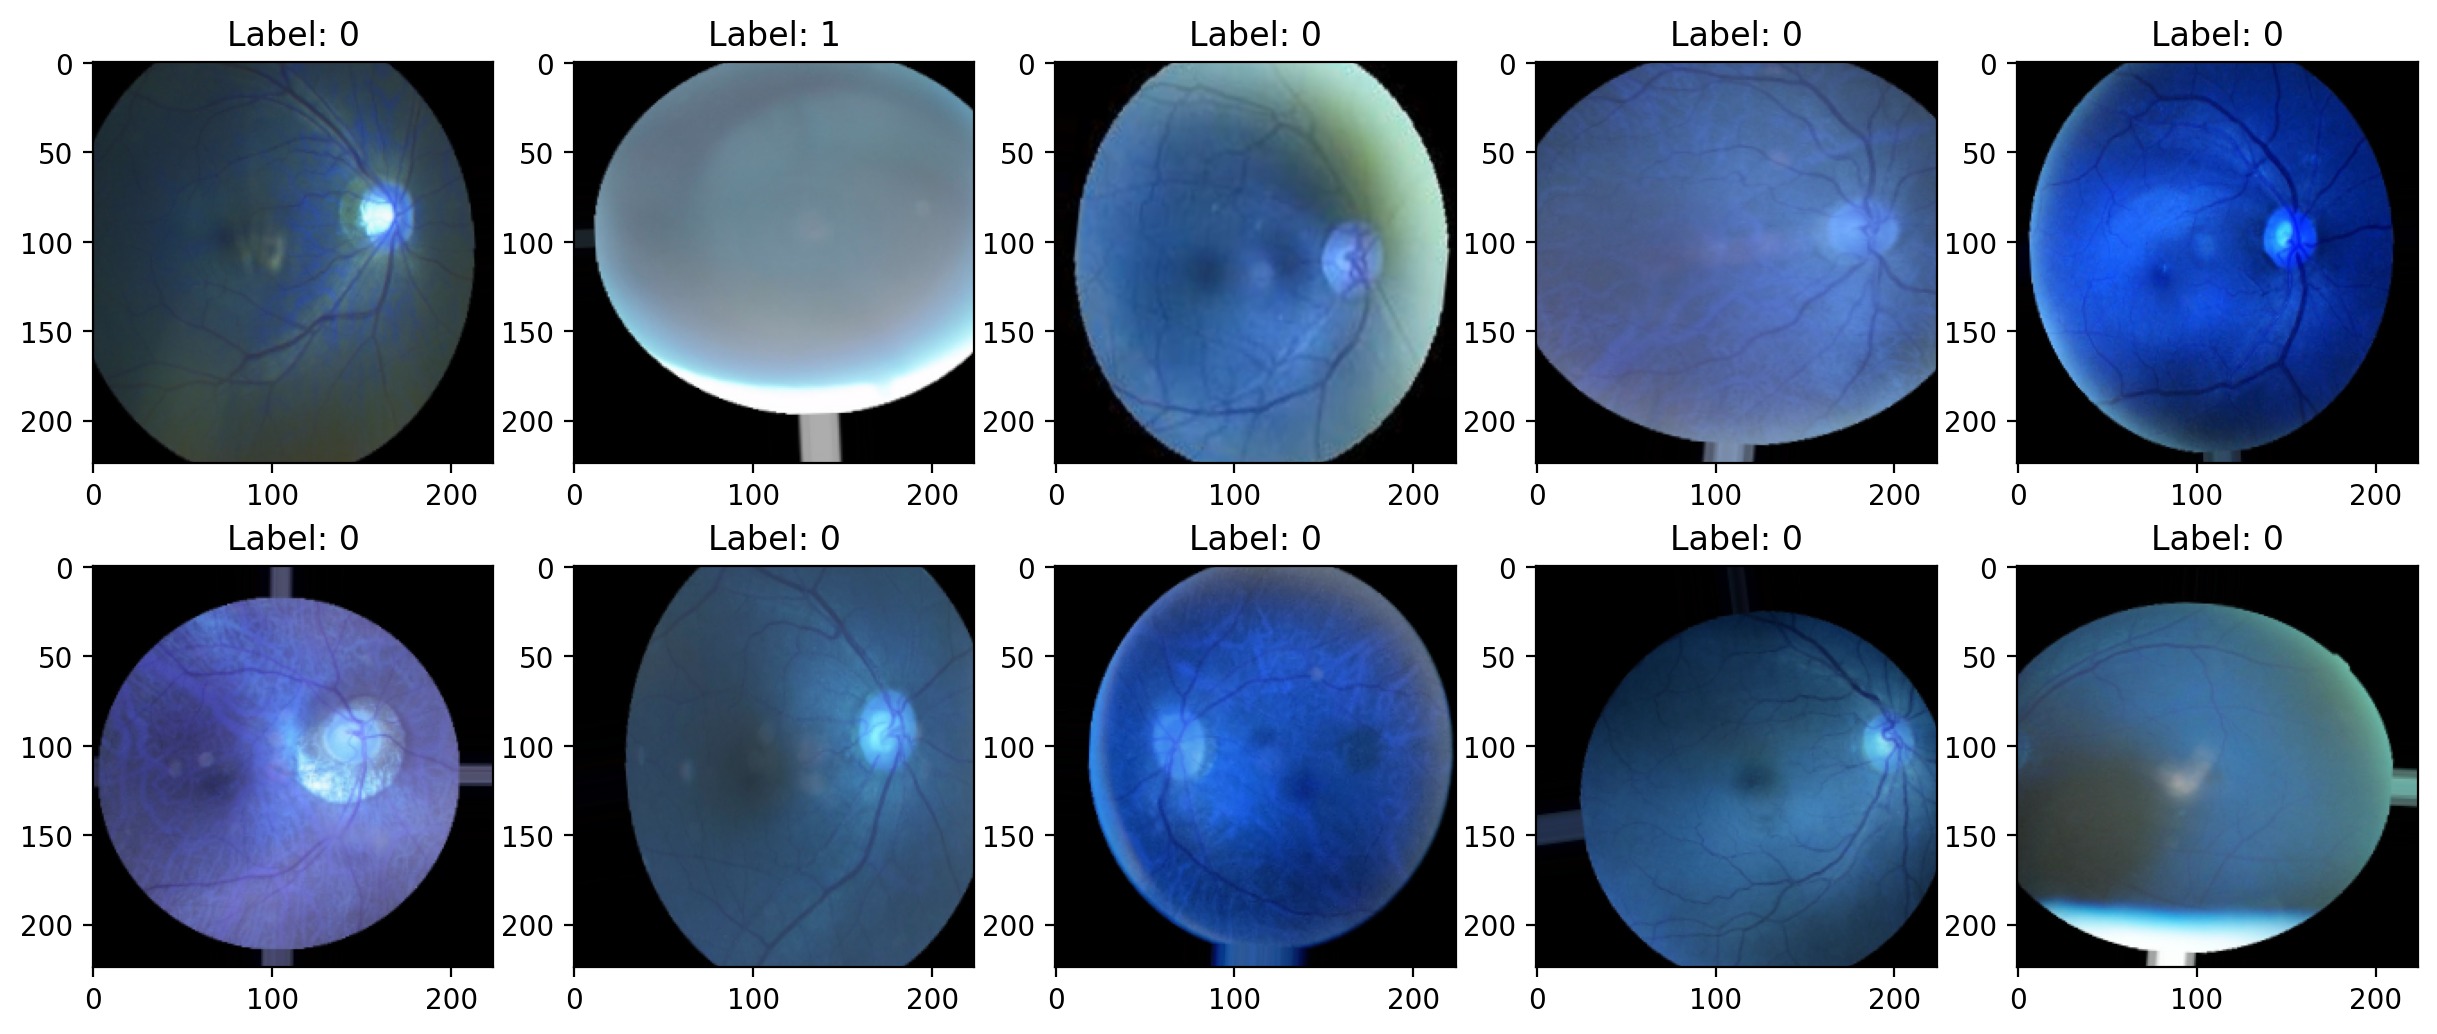

There are 70 images labeled 1 in cluster 4.
There are 263 images labeled 0 in cluster 4.
Average intra-cluster distance: 367.8504206487309


In [ ]:

cluster4_indices = np.where(cluster_labels == 3)[0]

# randomly select 10 indices from the cluster
random_indices = random.sample(list(cluster4_indices), 10)

# plot the randomly selected images
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axs = axs.ravel()
for i, index in enumerate(random_indices):
    axs[i].imshow(x_aug[index]/255)
    axs[i].set_title(f"Label: {y_aug[index]}")
plt.show()

c4_num_label_1 = np.count_nonzero(y_aug[cluster4_indices] == 1)

print(f"There are {c4_num_label_1} images labeled 1 in cluster 4.")

c4_num_label_0 = np.count_nonzero(y_aug[cluster4_indices] == 0)

print(f"There are {c4_num_label_0} images labeled 0 in cluster 4.")

cluster4_features = principalComponents[cluster4_indices]

distances = pdist(cluster4_features)
distance_matrix = squareform(distances)

# calculate average intra-cluster distance
intra_cluster_distance = np.mean(distance_matrix)

print("Average intra-cluster distance:", intra_cluster_distance)

<Axes: >

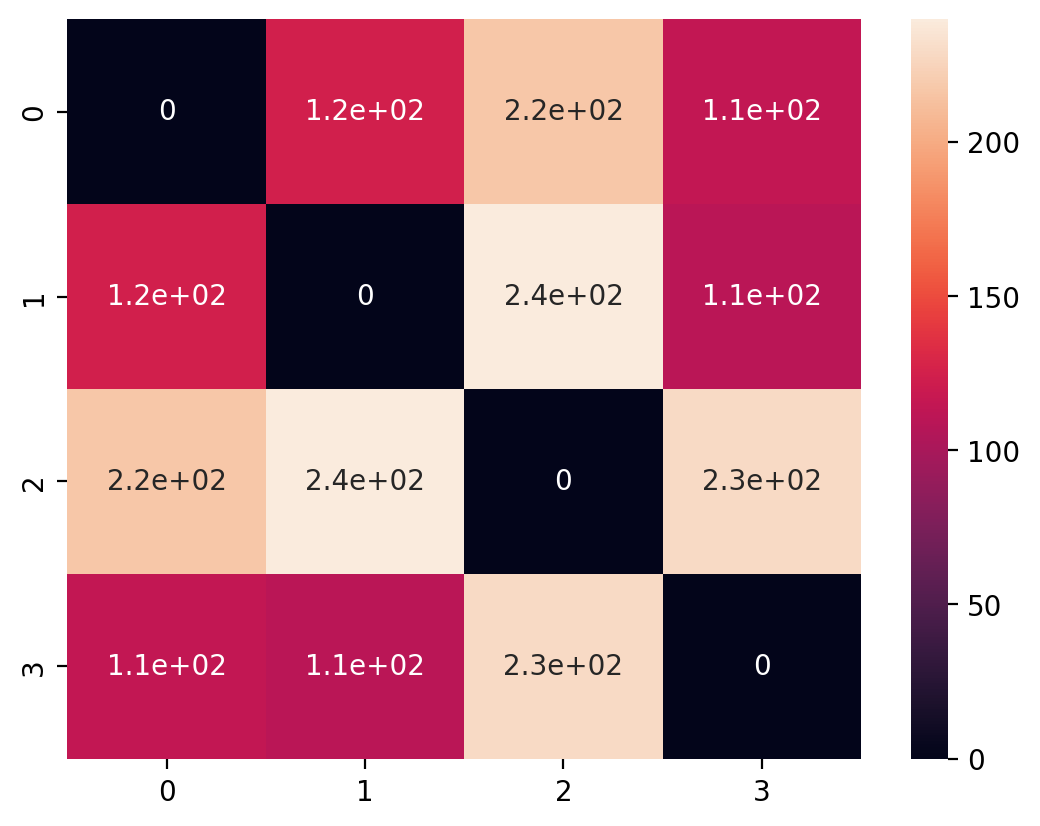

In [ ]:
# get centroids and distance matrix
import seaborn as sns
k =4
centroids = kmeans.cluster_centers_
dist_matrix = np.zeros((k, k))
for i in range(k):
    for j in range(i+1, k):
        dist_matrix[i, j] = np.linalg.norm(centroids[i] - centroids[j])
        dist_matrix[j, i] = dist_matrix[i, j]

# plot heatmap of distance matrix
sns.heatmap(dist_matrix, annot=True)

In [ ]:
centroids = kmeans.cluster_centers_

# Calculate the distances between each pair of centroids
distances = []
for i in range(4):
    for j in range(i+1, 4):
        centroid1 = centroids[i]
        centroid2 = centroids[j]
        distance = np.linalg.norm(centroid1-centroid2)
        distances.append(distance)

# Print the distances
print(distances)

[124.006424, 216.95627, 114.64332, 239.65526, 109.81989, 228.76137]


[110.06983, 117.48036, 58.25625, 45.92842, 76.19793, 85.9629] # centroid distances

In [ ]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = test_features_df.index.values
cluster_map['cluster'] = test_cluster_labels
c0_test = cluster_map[cluster_map.cluster == 0]
print(len(c0_test))
y0_test = np.array([y_testall[i] for i in c0_test.data_index])
print(len(y0_test))

100
100


In [ ]:
x0_test = np.array([x_testall[i] for i in c0_test.data_index])
x0_test.shape

(100, 224, 224, 3)

In [ ]:
test_loss, test_acc = base_model.evaluate(x0_test, y0_test, batch_size=1)

100/100 [==============================] - 10s 84ms/step - loss: 0.4167 - accuracy: 0.9600


Base model testing acc for cluster 1 is 0.8548.

In [ ]:
c1_test = cluster_map[cluster_map.cluster == 1]
print(len(c1_test))
y1_test = np.array([y_testall[i] for i in c1_test.data_index])
print(len(y1_test))
x1_test = np.array([x_testall[i] for i in c1_test.data_index])
x1_test.shape

96
96


(96, 224, 224, 3)

In [ ]:
test_loss, test_acc = base_model.evaluate(x1_test, y1_test, batch_size=1)

96/96 [==============================] - 8s 79ms/step - loss: 0.3285 - accuracy: 0.9792


In [ ]:
c2_test = cluster_map[cluster_map.cluster == 2]
print(len(c2_test))
y2_test = np.array([y_testall[i] for i in c2_test.data_index])
print(len(y2_test))
x2_test = np.array([x_testall[i] for i in c2_test.data_index])
x2_test.shape

2
2


(2, 224, 224, 3)

In [ ]:
test_loss, test_acc = base_model.evaluate(x2_test, y2_test, batch_size=1)

2/2 [==============================] - 0s 72ms/step - loss: 2.5485e-13 - accuracy: 1.0000


In [ ]:
c3_test = cluster_map[cluster_map.cluster == 3]
print(len(c3_test))
y3_test = np.array([y_testall[i] for i in c3_test.data_index])
print(len(y3_test))
x3_test = np.array([x_testall[i] for i in c3_test.data_index])
x3_test.shape

10
10


(10, 224, 224, 3)

In [ ]:
test_loss, test_acc = base_model.evaluate(x3_test, y3_test, batch_size=1)

10/10 [==============================] - 1s 76ms/step - loss: 7.5149e-07 - accuracy: 1.0000


In [ ]:
cluster1_features = principalComponents[cluster_labels == 0]
cluster2_features = principalComponents[cluster_labels == 1]
cluster3_features = principalComponents[cluster_labels == 2]
cluster4_features = principalComponents[cluster_labels == 3]
print(cluster1_features.shape)
print(cluster2_features.shape)
print(cluster3_features.shape)
print(cluster4_features.shape)

(762, 200)
(519, 200)
(42, 200)
(333, 200)


In [ ]:
#X = pd.DataFrame(X)

cluster_map = pd.DataFrame()
cluster_map['data_index'] = features_df.index.values
cluster_map['cluster'] = cluster_labels
c0 = cluster_map[cluster_map.cluster == 0]
print(len(c0))
y0 = np.array([y_aug[i] for i in c0.data_index])
print(len(y0))

762
762


In [ ]:
c1 = cluster_map[cluster_map.cluster == 1]
y1 = np.array([y_aug[i] for i in c1.data_index])
len(y1)

519

In [ ]:
c2 = cluster_map[cluster_map.cluster == 2]
y2 = np.array([y_aug[i] for i in c2.data_index])
len(y2)

42

In [ ]:
c3 = cluster_map[cluster_map.cluster == 3]
y3 = np.array([y_aug[i] for i in c3.data_index])
len(y3)

333

In [ ]:
print(c0.data_index)

0          0
1          1
2          2
3          3
4          4
        ... 
1616    1616
1621    1621
1627    1627
1643    1643
1646    1646
Name: data_index, Length: 762, dtype: int64


In [ ]:
x0 = np.array([x_aug[i] for i in c0.data_index])
y0 = np.array([y_aug[i] for i in c0.data_index])
x0.shape

(762, 224, 224, 3)

In [ ]:
x1 = np.array([x_aug[i] for i in c1.data_index])
y1 = np.array([y_aug[i] for i in c1.data_index])
x1.shape

(519, 224, 224, 3)

In [ ]:
x2 = np.array([x_aug[i] for i in c2.data_index])
y2 = np.array([y_aug[i] for i in c2.data_index])
x2.shape

(42, 224, 224, 3)

In [ ]:
x3 = np.array([x_aug[i] for i in c3.data_index])
y3 = np.array([y_aug[i] for i in c3.data_index])
x3.shape

(333, 224, 224, 3)

In [ ]:
from keras.applications.efficientnet import EfficientNetB0
efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

for layer in efficientnet.layers:
    layer.trainable = False

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense

model1 = Sequential()
model1.add(efficientnet)
model1.add(Flatten())
model1.add(Dense(1,activation="sigmoid"))
model1.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("c0_efficientnet.h5", monitor="val_accuracy", verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1, mode='auto', restore_best_weights=True)
history2 = model1.fit(x0, y0, batch_size=8, epochs=10, validation_data=(x_testall, y_testall), verbose=1, callbacks = [checkpoint, earlystop])

Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 0.4743 - accuracy: 0.9291
Epoch 1: val_accuracy improved from -inf to 0.93269, saving model to c0_efficientnet.h5
96/96 [==============================] - 74s 704ms/step - loss: 0.4743 - accuracy: 0.9291 - val_loss: 0.5705 - val_accuracy: 0.9327
Epoch 2/10
96/96 [==============================] - ETA: 0s - loss: 0.4141 - accuracy: 0.9383
Epoch 2: val_accuracy did not improve from 0.93269
96/96 [==============================] - 65s 683ms/step - loss: 0.4141 - accuracy: 0.9383 - val_loss: 1.2590 - val_accuracy: 0.9327
Epoch 3/10
96/96 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.9685
Epoch 3: val_accuracy improved from 0.93269 to 0.94231, saving model to c0_efficientnet.h5
96/96 [==============================] - 66s 685ms/step - loss: 0.1336 - accuracy: 0.9685 - val_loss: 0.8898 - val_accuracy: 0.9423
Epoch 4/10
96/96 [==============================] - ETA: 0s - loss: 0.1048 - accuracy: 0.975

7/7 [==============================] - 18s 2s/step
Accuracy: 95.19%
AUC Score: 0.97
Sensitivity: 94.23%
Specificity: 96.15%


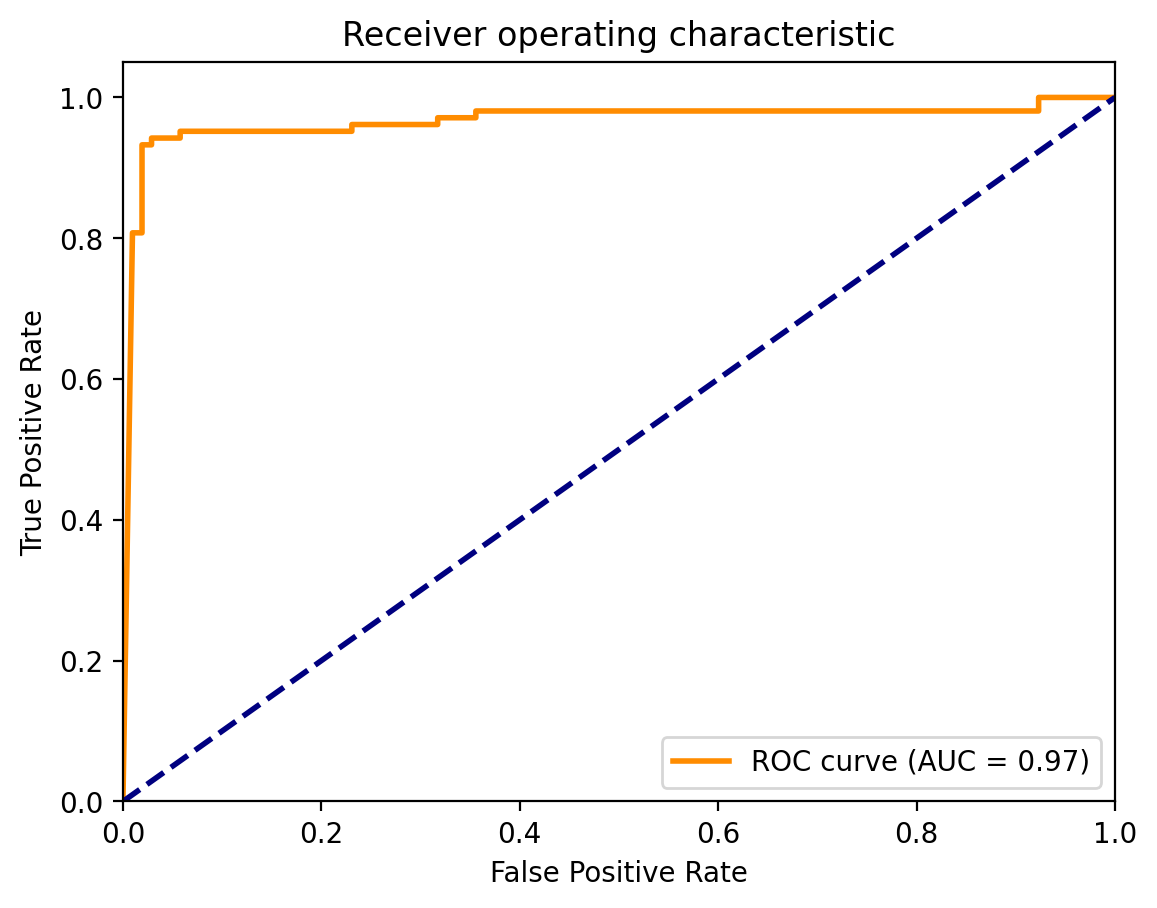

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Make predictions on the test set
predictions = model1.predict(x_testall)

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_testall, predictions)

# Compute the AUC score
auc_score = roc_auc_score(y_testall, predictions)

# Print the performance metrics
print("Accuracy: {:.2f}%".format(accuracy_score(y_testall, np.round(predictions)) * 100))
print("AUC Score: {:.2f}".format(auc_score))
tn, fp, fn, tp = confusion_matrix(y_testall, np.round(predictions)).ravel()
print("Sensitivity: {:.2f}%".format(tp / (tp + fn) * 100))
print("Specificity: {:.2f}%".format(tn / (tn + fp) * 100))

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from keras.applications.efficientnet import EfficientNetB0
efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

for layer in efficientnet.layers:
    layer.trainable = False

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense

model2 = Sequential()
model2.add(efficientnet)
model2.add(Flatten())
model2.add(Dense(1,activation="sigmoid"))
model2.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("c1_efficientnet.h5", monitor="val_accuracy", verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor="val_accuracy", patience=3, verbose=1, mode='auto', restore_best_weights=True)
history3 = model2.fit(x1, y1, batch_size=8, epochs=10, validation_data=(x_testall, y_testall), verbose=1, callbacks = [checkpoint, earlystop])

Epoch 1/10
65/65 [==============================] - ETA: 0s - loss: 0.5997 - accuracy: 0.9441
Epoch 1: val_accuracy improved from -inf to 0.65865, saving model to c1_efficientnet.h5
65/65 [==============================] - 62s 852ms/step - loss: 0.5997 - accuracy: 0.9441 - val_loss: 1.0524 - val_accuracy: 0.6587
Epoch 2/10
65/65 [==============================] - ETA: 0s - loss: 0.0789 - accuracy: 0.9846
Epoch 2: val_accuracy did not improve from 0.65865
65/65 [==============================] - 52s 798ms/step - loss: 0.0789 - accuracy: 0.9846 - val_loss: 2.0204 - val_accuracy: 0.5962
Epoch 3/10
65/65 [==============================] - ETA: 0s - loss: 0.2383 - accuracy: 0.9615
Epoch 3: val_accuracy improved from 0.65865 to 0.68750, saving model to c1_efficientnet.h5
65/65 [==============================] - 52s 802ms/step - loss: 0.2383 - accuracy: 0.9615 - val_loss: 1.3426 - val_accuracy: 0.6875
Epoch 4/10
65/65 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.969

7/7 [==============================] - 18s 2s/step
Accuracy: 68.75%
AUC Score: 0.93
Sensitivity: 41.35%
Specificity: 96.15%


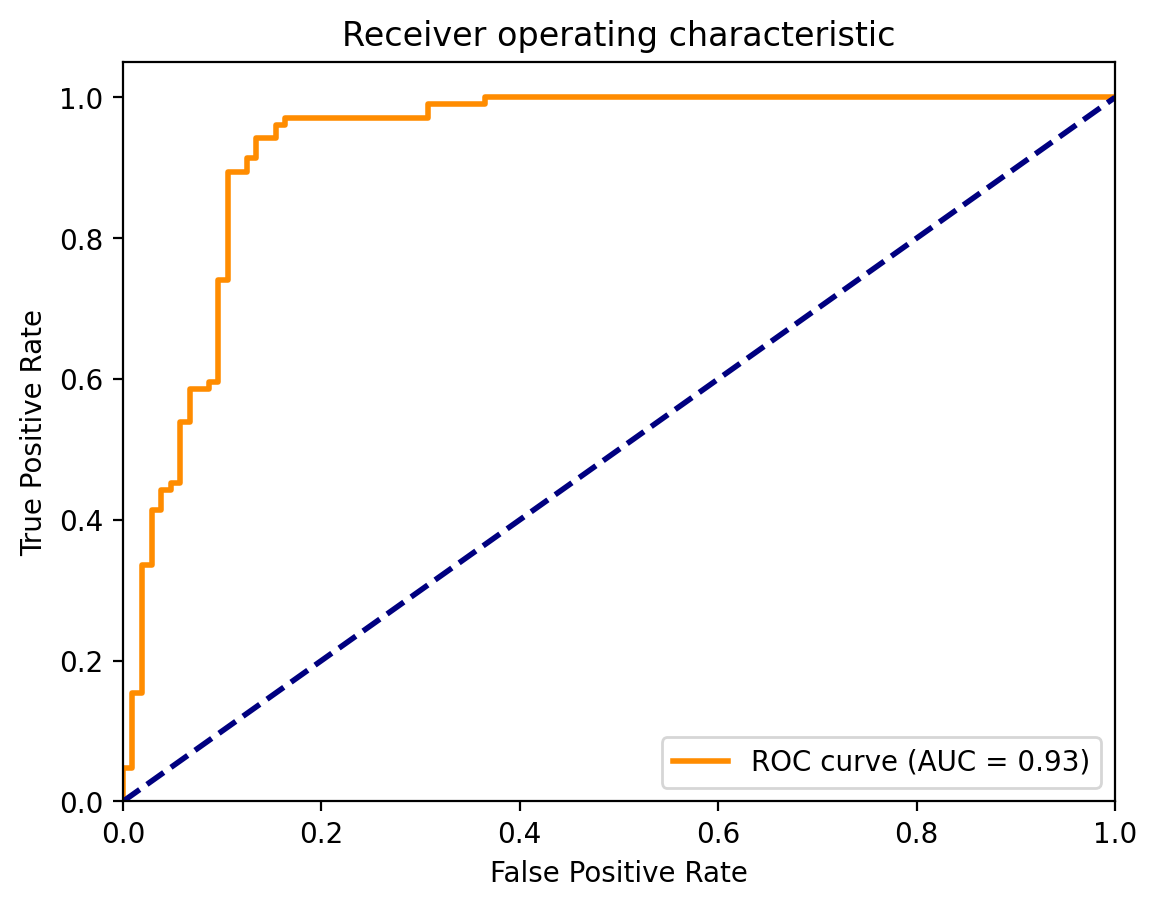

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Make predictions on the test set
predictions = model2.predict(x_testall)

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_testall, predictions)

# Compute the AUC score
auc_score = roc_auc_score(y_testall, predictions)

# Print the performance metrics
print("Accuracy: {:.2f}%".format(accuracy_score(y_testall, np.round(predictions)) * 100))
print("AUC Score: {:.2f}".format(auc_score))
tn, fp, fn, tp = confusion_matrix(y_testall, np.round(predictions)).ravel()
print("Sensitivity: {:.2f}%".format(tp / (tp + fn) * 100))
print("Specificity: {:.2f}%".format(tn / (tn + fp) * 100))

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from keras.applications.efficientnet import EfficientNetB0
efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

for layer in efficientnet.layers:
    layer.trainable = False

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense

model3 = Sequential()
model3.add(efficientnet)
model3.add(Flatten())
model3.add(Dense(1,activation="sigmoid"))
model3.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("c2_efficientnet.h5", monitor="val_accuracy", verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor="val_accuracy", patience=3, verbose=1, mode='auto', restore_best_weights=True)
history4 = model3.fit(x2, y2, batch_size=8, epochs=10, validation_data=(x_testall, y_testall), verbose=1, callbacks = [checkpoint, earlystop])

Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 0.2105 - accuracy: 0.8571
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to c2_efficientnet.h5
6/6 [==============================] - 26s 4s/step - loss: 0.2105 - accuracy: 0.8571 - val_loss: 13.1585 - val_accuracy: 0.5000
Epoch 2/10
6/6 [==============================] - ETA: 0s - loss: 1.4987e-20 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.50000
6/6 [==============================] - 16s 3s/step - loss: 1.4987e-20 - accuracy: 1.0000 - val_loss: 18.1185 - val_accuracy: 0.5000
Epoch 3/10
6/6 [==============================] - ETA: 0s - loss: 6.6184e-27 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.50000
6/6 [==============================] - 17s 3s/step - loss: 6.6184e-27 - accuracy: 1.0000 - val_loss: 20.7419 - val_accuracy: 0.5000
Epoch 4/10
6/6 [==============================] - ETA: 0s - loss: 8.3492e-29 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve 

7/7 [==============================] - 19s 2s/step
Accuracy: 50.00%
AUC Score: 0.50
Sensitivity: 100.00%
Specificity: 0.00%


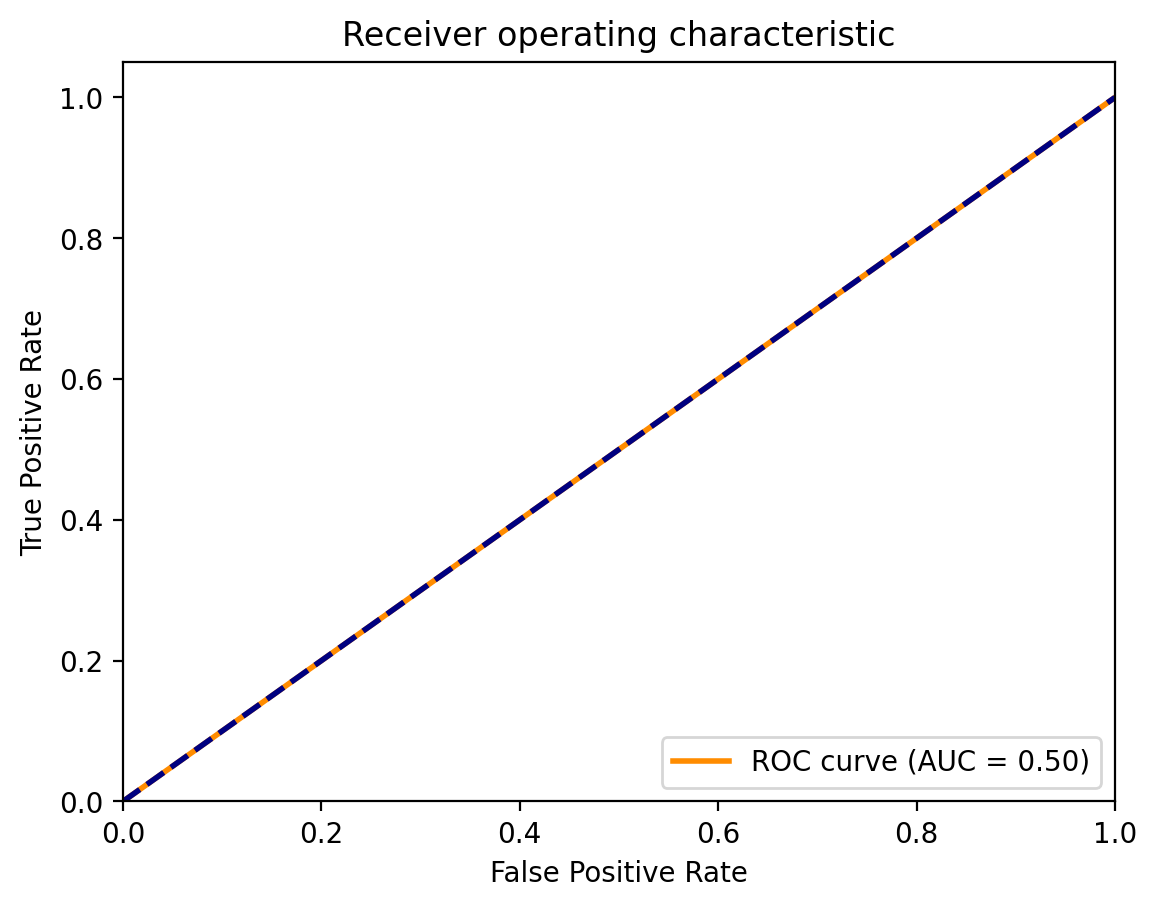

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Make predictions on the test set
predictions = model3.predict(x_testall)

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_testall, predictions)

# Compute the AUC score
auc_score = roc_auc_score(y_testall, predictions)

# Print the performance metrics
print("Accuracy: {:.2f}%".format(accuracy_score(y_testall, np.round(predictions)) * 100))
print("AUC Score: {:.2f}".format(auc_score))
tn, fp, fn, tp = confusion_matrix(y_testall, np.round(predictions)).ravel()
print("Sensitivity: {:.2f}%".format(tp / (tp + fn) * 100))
print("Specificity: {:.2f}%".format(tn / (tn + fp) * 100))

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from keras.applications.efficientnet import EfficientNetB0
efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

for layer in efficientnet.layers:
    layer.trainable = False

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense

model4 = Sequential()
model4.add(efficientnet)
model4.add(Flatten())
model4.add(Dense(1,activation="sigmoid"))
model4.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("c3_efficientnet.h5", monitor="val_accuracy", verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor="val_accuracy", patience=3, verbose=1, mode='auto', restore_best_weights=True)
history5 = model4.fit(x3, y3, batch_size=8, epochs=10, validation_data=(x_testall, y_testall), verbose=1, callbacks = [checkpoint, earlystop])

Epoch 1/10
42/42 [==============================] - ETA: 0s - loss: 1.0066 - accuracy: 0.8228
Epoch 1: val_accuracy improved from -inf to 0.88942, saving model to c3_efficientnet.h5
42/42 [==============================] - 46s 916ms/step - loss: 1.0066 - accuracy: 0.8228 - val_loss: 0.7221 - val_accuracy: 0.8894
Epoch 2/10
42/42 [==============================] - ETA: 0s - loss: 0.5356 - accuracy: 0.9009
Epoch 2: val_accuracy improved from 0.88942 to 0.92308, saving model to c3_efficientnet.h5
42/42 [==============================] - 36s 877ms/step - loss: 0.5356 - accuracy: 0.9009 - val_loss: 0.5925 - val_accuracy: 0.9231
Epoch 3/10
42/42 [==============================] - ETA: 0s - loss: 0.1369 - accuracy: 0.9760
Epoch 3: val_accuracy did not improve from 0.92308
42/42 [==============================] - 36s 856ms/step - loss: 0.1369 - accuracy: 0.9760 - val_loss: 0.5263 - val_accuracy: 0.9231
Epoch 4/10
42/42 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.982

7/7 [==============================] - 18s 2s/step
Accuracy: 93.75%
AUC Score: 0.97
Sensitivity: 95.19%
Specificity: 92.31%


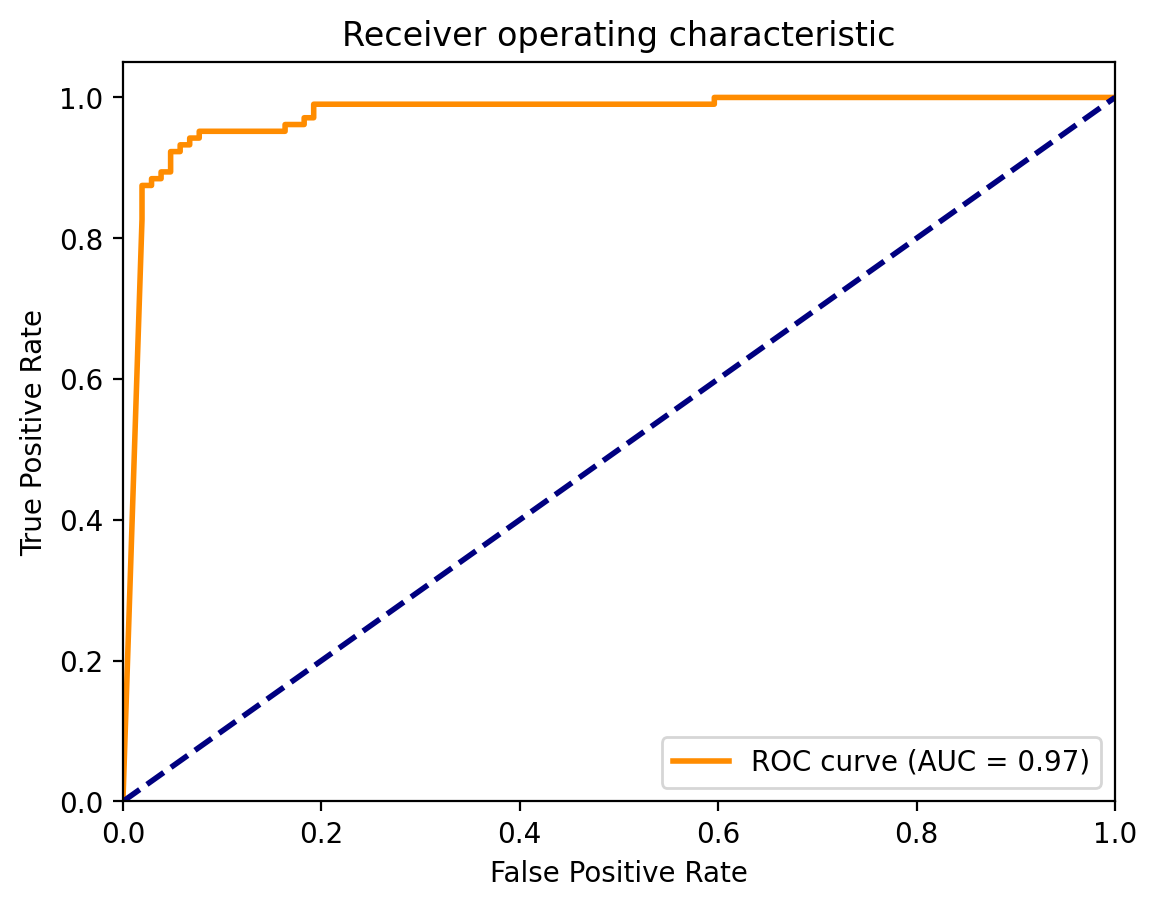

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Make predictions on the test set
predictions = model4.predict(x_testall)

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_testall, predictions)

# Compute the AUC score
auc_score = roc_auc_score(y_testall, predictions)

# Print the performance metrics
print("Accuracy: {:.2f}%".format(accuracy_score(y_testall, np.round(predictions)) * 100))
print("AUC Score: {:.2f}".format(auc_score))
tn, fp, fn, tp = confusion_matrix(y_testall, np.round(predictions)).ravel()
print("Sensitivity: {:.2f}%".format(tp / (tp + fn) * 100))
print("Specificity: {:.2f}%".format(tn / (tn + fp) * 100))

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()